In this project we propose to create an item-item recommendation system that will assist users in selecting the next title to watch based on their input of a specific title. We will adopt this approach instead of building user profiles, so the imputed title will be used in lieu of a user profile, however user profile data is available that we may incorporate into our project later, time allowing.

We have begun setting up our item-item system, but we have not progressed very far. We are currently using a truncated version of our ratings file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

ratings_df = pd.read_csv("./input/ratings_small.csv", dtype = 'float')
ratings_df.head()

movies_df = pd.read_csv("./input/movies_metadata.csv")
movies_df.head()

movies_df = movies_df[movies_df['id'].astype(str).str.isdigit()] # clean (Some movies have not integers as id)
movies_df.id = movies_df.id.astype(np.int64)

ratings_df = pd.merge(ratings_df,movies_df[['title','id']],left_on='movieId',right_on='id')
ratings_df.head()

ratings_df.drop(['timestamp','id'],axis=1,inplace=True)

titles = ratings_df["title"].unique()
titlesRate = []
titlesVote = []

for t in range(len(titles)):
    temp = ratings_df[(ratings_df["title"] == titles[t])]
    v = temp['rating'].mean()
    titlesVote.append(temp['rating'].count())
    titlesRate.append(v)

data = {'Title':  titles,
        'Rating': titlesRate,
        'Votes': titlesVote
       }
Leaderboard = pd.DataFrame (data, columns = ['Title','Rating','Votes'])


/home/kadekool/class/4022/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# Highly rated movies
print("Top rated movies")
Leaderboard = Leaderboard.sort_values(by=['Rating','Votes'], ascending = False).reset_index(drop = True)
print(Leaderboard.head(10))

print("Most viewed movies")
# Popular
Leaderboard = Leaderboard.sort_values(by=['Votes','Rating'], ascending = False).reset_index(drop = True)
print(Leaderboard.head(10))

Top rated movies
                      Title  Rating  Votes
0           The Celebration     5.0      3
1   The Night of the Hunter     5.0      3
2                 Ninotchka     5.0      2
3                 Silentium     5.0      2
4  Gentlemen Prefer Blondes     5.0      2
5                 Long Pigs     5.0      2
6              Nick of Time     5.0      1
7        The Crazy Stranger     5.0      1
8            The Inquisitor     5.0      1
9      Murder in Three Acts     5.0      1
Most viewed movies
                                Title    Rating  Votes
0  Terminator 3: Rise of the Machines  4.256173    324
1            The Million Dollar Hotel  4.487138    311
2                             Solaris  4.134426    305
3                        The 39 Steps  4.221649    291
4                     Monsoon Wedding  3.706204    274
5                  Once Were Warriors  4.303279    244
6                   Three Colors: Red  3.945175    228
7                     Men in Black II  4.256696    

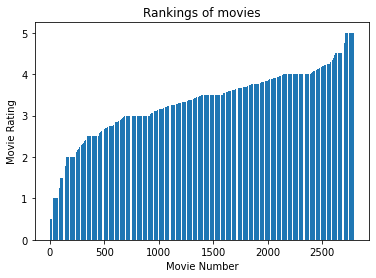

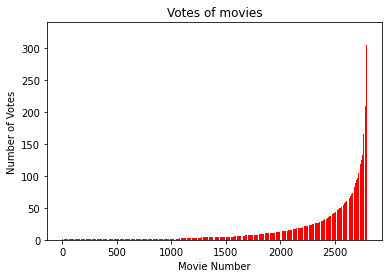

In [3]:
top_rated_movies = Leaderboard.sort_values(by=['Rating','Votes'], ascending = False).reset_index(drop = True)
top_rated_movies_y = sorted(top_rated_movies['Rating'].values.tolist())
top_rated_movies_x = [i for i in range(len(top_rated_movies_y))]

plt.bar(top_rated_movies_x, top_rated_movies_y)

plt.title('Rankings of movies')
plt.xlabel("Movie Number")
plt.ylabel("Movie Rating")
plt.show()

top_voted_movies_y = sorted(top_rated_movies['Votes'].values.tolist())
top_voted_movies_x = [i for i in range(len(top_rated_movies_y))]
plt.bar(top_voted_movies_x, top_voted_movies_y, color = 'red')

plt.title('Votes of movies')
plt.xlabel("Movie Number")
plt.ylabel("Number of Votes")
plt.show()


As you can see, we have cleaned and merged some data from our csv files. From these we calculated the most popular and high rated titles, as well as averages of the like. This is very important for recomendations! The better rated and ranked an item, the more likely it is to be recommended. It also is important to think about which items are popular in general and which items are specifically. Moving foward we will have to  run knn on the movies. Where the closest k movies will be suggested. Perhaps we can incorporate the rating of the movie in the way we list the movie recommendations to the user. 

In [4]:
movie_text = movies_df['overview'].values.tolist()
movie_text_check = movie_text.copy()
movie_text = [set(str(movie_text[i]).split()) for i in range(len(movie_text))]

movie_title = movies_df['original_title'].values.tolist()
movie_title = [movie_title[i] for i in range(len(movie_title))]
movie_title_set = set(movie_title)

movie_word_set = {movie_title[i]: movie_text[i] for i in range(len(movie_title))}
check_words = {movie_title[i]: movie_text_check[i] for i in range(len(movie_title))}

In [143]:
adult_store = {collection_titles[i] : c for i,c in enumerate(adult)}

def description_similarity(title, title_set = None, return_scores = False, return_text = False, return_all = False):
    if title not in movie_title_set:
        print("Title not found!")
        return []
    
    else:
        if title_set is None:
            ii = movie_title.index(title)
            title_set = movie_text[ii]
        
        i = 0
        j = -1
        current_leader = []
        while i < 10:
            j += 1
            if movie_title[j] == title or len(movie_text[j]) == 0:
                if return_text:
                    current_leader.append((movie_title[j], 1, movie_text[j]))
                else:
                    current_leader.append((movie_title[j], 1))
            else:
                if return_text:
                    current_leader.append((movie_title[j], len(movie_text[j].union(title_set))/(len(movie_text[j])+len(title_set)), movie_text[j]))
                else:
                    current_leader.append((movie_title[j], len(movie_text[j].union(title_set))/(len(movie_text[j])+len(title_set))))
            i += 1
        
        title_set = movie_word_set[title]

        for i, m_title in enumerate(movie_title[10:]):
            j = i + 10
            
            if m_title == title or len(movie_text[j]) == 0:
                current_leader.append((movie_title[j], 1))
                continue
                
            if return_text:
                current_leader.append((movie_title[j], len(movie_text[j].union(title_set))/(len(movie_text[j])+len(title_set)), movie_text[j]))
            else:
                current_leader.append((movie_title[j], len(movie_text[j].union(title_set))/(len(movie_text[j])+len(title_set))))
            
            if not return_all:
                current_leader.sort(key = lambda x:x[1])
                current_leader = current_leader[:-1]
            
        if return_scores or return_text:
            return current_leader
        else:
            return [x[0] for x in current_leader]
        
title = "Toy Story"
temp = description_similarity(title, return_scores = True)
# print([(x[0], x[1]) for x in temp])
# print()



In [115]:
if 'Toy Story' in check_words:
    print(check_words['Toy Story'])
    print()

if 'Les Fugitifs' in check_words:
    print(check_words['Les Fugitifs'])
    
ii = movie_title.index('Toy Story')
title_set = movie_text[ii]

iii = movie_title.index('Les Fugitifs')
title_set_two = movie_text[iii]

print(title_set.intersection(title_set_two))
print()
print(len(title_set.union(title_set_two)),len(title_set) + len(title_set_two))

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.

Coming out from jail, Lucas has decided to change his life and behave like a good citizen. But when he is taken hostage in a bank by a hare-brained robber, no cops can believe he is not part of the action.
{'to', 'of', 'the', 'But', 'his', 'by', 'and', 'when', 'from', 'in'}

69 79


In [144]:
collection = movies_df['belongs_to_collection']
collection_titles = movies_df['original_title'].values.tolist()
collection_store = {collection_titles[i] : ast.literal_eval(c)['name'] if isinstance(c, str) else None for i,c in enumerate(collection.values.tolist())}

def collection_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = collection_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if collection_store[movie_title[i]] is not None:           
            if collection_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
                
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(collection_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 1), ('Grumpier Old Men', 1), ('Waiting to Exhale', 1), ('Father of the Bride Part II', 1), ('Heat', 1), ('Sabrina', 1), ('Tom and Huck', 1), ('Sudden Death', 1), ('GoldenEye', 1)]


In [145]:
adult = movies_df['adult'].values.tolist()
adult_store = {collection_titles[i] : c for i,c in enumerate(adult)}

def adult_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = adult_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if adult_store[movie_title[i]] is not None:           
            if adult_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(adult_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 0), ('Grumpier Old Men', 0), ('Waiting to Exhale', 0), ('Father of the Bride Part II', 0), ('Heat', 0), ('Sabrina', 0), ('Tom and Huck', 0), ('Sudden Death', 0), ('GoldenEye', 0)]


In [146]:
language = movies_df['original_language'].values.tolist()
language_store = {collection_titles[i] : c for i,c in enumerate(language)}

def language_similarity(title, title_collection = None, return_all = False):
    temp = []
    
    if title_collection is None:
            title_collection = adult_store[title]
            
    for i in range(len(movie_title)):
        
        if movie_title[i] == title:
            temp.append((movie_title[i],1))
            continue
            
        if language_store[movie_title[i]] is not None:           
            if language_store[movie_title[i]] == title_collection:
                temp.append((movie_title[i],0))
                
            else:
                temp.append((movie_title[i],1))
        else:
            temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
    if return_all:
        return temp
    else:
        return temp[:10]
        
print(language_similarity('Toy Story'))


[('Toy Story', 1), ('Jumanji', 1), ('Grumpier Old Men', 1), ('Waiting to Exhale', 1), ('Father of the Bride Part II', 1), ('Heat', 1), ('Sabrina', 1), ('Tom and Huck', 1), ('Sudden Death', 1), ('GoldenEye', 1)]


In [ ]:
# genre = movies_df['genres'].values.tolist()
# genre_store = {collection_titles[i] : c for i,c in enumerate(genre)}

# def genre_similarity(title, title_collection = None, return_all = False):
#     temp = []
    
#     if title_collection is None:
#             title_collection = genre_store[title]
            
#     for i in range(len(movie_title)):
        
#         if movie_title[i] == title:
#             continue
            
#         if genre_store[movie_title[i]] is not None:           
#             if genre_store[movie_title[i]] == title_collection:
#                 temp.append((movie_title[i],0))
                
#             else:
#                 temp.append((movie_title[i],1))
#         else:
#             temp.append((movie_title[i],1))
            
#     temp.sort(key = lambda x:x[1])  
    
#     if return_all:
#         return temp
#     else:
#         return temp[:10]
        
# print(language_similarity('Toy Story'))

In [160]:
def combine(title, scores = [5,2,5,1,3]):
    collection = collection_similarity(title, return_all = True)
    description = description_similarity(title, return_scores = True, return_all = True)
    language = language_similarity(title, return_all = True)
    adult = adult_similarity(title, return_all = True)
#     for i in range(1,len(description)):
#         if description[i-1][0] == description[i][0]:
#             description = description[:i-1] + description[i:]
#             break
    print(len(collection), len(description), len(language), len(adult))
    temp = []
    
    for i in range(len(movie_title)-2):
        
        if movie_title[i] == title or movie_title[i] not in adult_store:
            continue
#         print(scores[0]*adult[i][1])
#         print(scores[0]*language[i][1])
#         print(scores[0]*collection[i][1])
#         print(adult[i][1], language[i][1], collection[i][1], description[i][1])
#         print(adult[i][0],"  ", language[i][0], "  ",  collection[i][0], "  ", description[i][0])
#         print(movie_title[i], scores[0]*adult[i+1][1], scores[1]*language[i+1][1], scores[2]*collection[i+1][1], scores[3]*description[i+1][1], scores[0]*adult[i+1][1] + scores[1]*language[i+1][1] + scores[2]*collection[i+1][1] + scores[3]*description[i+1][1])
        temp.append((movie_title[i],scores[0]*adult[i][1] + scores[1]*language[i][1] + scores[2]*collection[i][1] + scores[3]*description[i][1]))
    temp.sort(key = lambda x:x[1])
    return temp[:10]

print(combine("Batman v Superman: Dawn of Justice"))

45463 45463 45463 45463
[('Man of Steel', 2.9207920792079207), ('Backstage', 7.8807339449541285), ('Batman & Robin', 7.882978723404255), ('Sevmek Zamanı', 7.883116883116883), ('Thirteen', 7.883495145631068), ('Batman: The Dark Knight Returns, Part 1', 7.88421052631579), ('Kill Kane', 7.88421052631579), ('Rasputin', 7.885057471264368), ('Trancers 6: Life After Deth', 7.885964912280702), ('Lego Batman: The Movie - DC Super Heroes Unite', 7.8875)]
